<a href="https://colab.research.google.com/github/keshavga1209/yeagerists/blob/master/jupyter-nb/InceptionV3_Foot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd drive/MyDrive


/content/drive/MyDrive


In [2]:
from fastai.imports import *


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
import matplotlib.image as mpimg

path = Path("hack_the_tank/dataset2")
print(path)
print(os.listdir("hack_the_tank/dataset2"))

hack_the_tank/dataset2
['NORMAL', 'FLAT', 'HIGH']


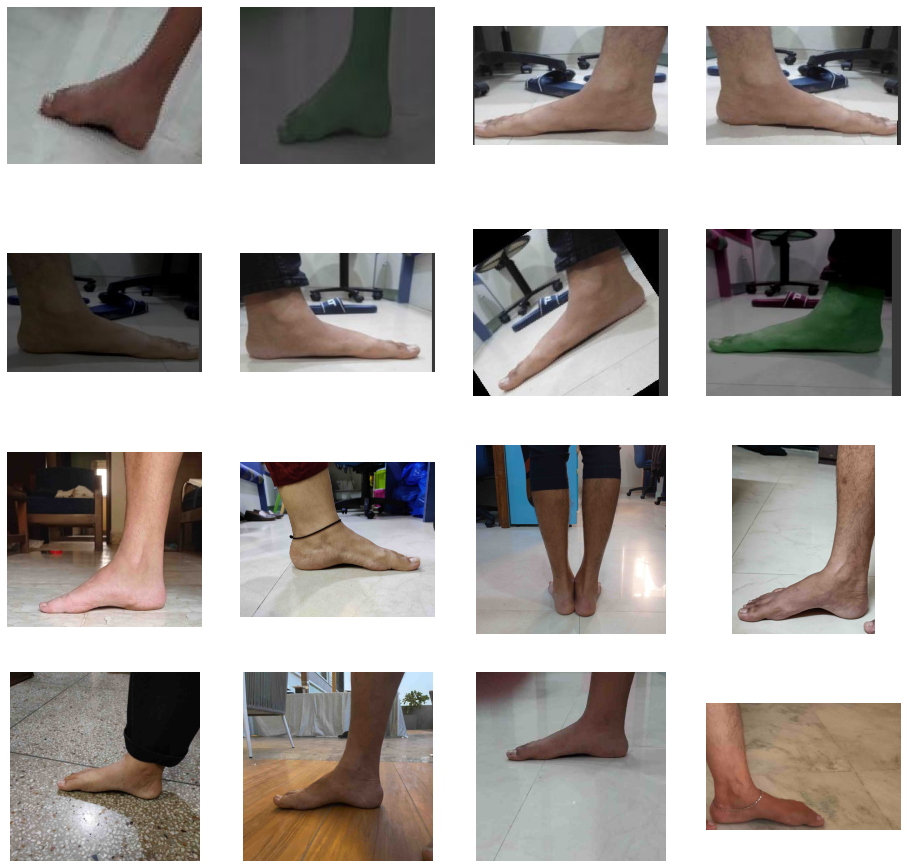

In [4]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

high_dir = os.path.join('hack_the_tank/dataset2/HIGH')
flat_dir = os.path.join('hack_the_tank/dataset2/FLAT')
normal_dir = os.path.join('hack_the_tank/dataset2/NORMAL')

high_names = os.listdir(high_dir)
flat_names = os.listdir(flat_dir)
normal_names = os.listdir(normal_dir)

pic_index = 210

high_images = [os.path.join(high_dir, fname)
			for fname in high_names[pic_index-8:pic_index]]
flat_images = [os.path.join(flat_dir, fname)
			for fname in flat_names[pic_index-8:pic_index]]
normal_images = [os.path.join(normal_dir, fname)
			for fname in normal_names[pic_index-8:pic_index]]

for i, img_path in enumerate(high_images + flat_images + normal_images):
	sp = plt.subplot(4, 4, i+1)
	sp.axis('Off')

	img = mpimg.imread(img_path)
	plt.imshow(img)

plt.show()


In [5]:
base_dir = 'hack_the_tank/dataset2'

# Create datasets
train_datagen = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
												image_size=(200,200),
												subset='training',
												seed = 5,
												validation_split=0.1,
												batch_size= 32,
                        shuffle= True)
test_datagen = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
												image_size=(200,200),
												subset='validation',
												seed = 5,
												validation_split=0.1,
												batch_size= 32,
                        shuffle= True)


print(train_datagen.class_names)


Found 698 files belonging to 3 classes.
Using 629 files for training.
Found 698 files belonging to 3 classes.
Using 69 files for validation.
['FLAT', 'HIGH', 'NORMAL']


In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(
	input_shape=(200, 200, 3),
	weights='imagenet',
	include_top=False
)

#base_model.trainable=False

for layer in base_model.layers:
  layer.trainable = False
  
last_layer = base_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output



87910968/87910968 [==============================] - 3s 0us/step
last layer output shape:  (None, 10, 10, 768)


In [7]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(base_model.input, output)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(output.shape)

(None, 3)


In [26]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_auc') > 0.99:
			print('\n Validation accuracy has reached upto 90%\
	so, stopping further training.')
			self.model.stop_training = True

es = EarlyStopping(patience=3,
				monitor='val_auc',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


['FLAT', 'HIGH', 'NORMAL']


TypeError: ignored

In [60]:
#chatGPT suggested to hot encode 


from keras.utils import to_categorical

class_names = train_datagen.class_names # Get the class names from the generator
num_classes = len(class_names)

# train_labels = to_categorical(train_labels, num_classes=3)
# test_labels = to_categorical(test_labels, num_classes=3)


train_labels = train_datagen.map(lambda x, y: y) # Extract label data from generator
test_labels = test_datagen.map(lambda x, y: y)


train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)


TypeError: ignored

In [8]:
# history = model.fit(train_datagen,
# 		epochs=10,
# 		validation_data=test_datagen)
history = model.fit(train_datagen,
                    epochs=10,
                    validation_data=test_datagen,
                    batch_size = 32
                    # steps_per_epoch=len(train_datagen),
                    # validation_steps=len(test_datagen),
                    )

Epoch 1/10
20/20 [==============================] - 149s 5s/step - loss: 1.2711 - accuracy: 0.5183 - val_loss: 3.2310 - val_accuracy: 0.2464
Epoch 2/10
20/20 [==============================] - 46s 2s/step - loss: 0.8572 - accuracy: 0.6614 - val_loss: 0.8286 - val_accuracy: 0.6812
Epoch 3/10
20/20 [==============================] - 46s 2s/step - loss: 0.7681 - accuracy: 0.6725 - val_loss: 0.6984 - val_accuracy: 0.7536
Epoch 4/10
20/20 [==============================] - 46s 2s/step - loss: 0.5973 - accuracy: 0.7647 - val_loss: 0.7159 - val_accuracy: 0.7971
Epoch 5/10
20/20 [==============================] - 46s 2s/step - loss: 0.4892 - accuracy: 0.8203 - val_loss: 0.7135 - val_accuracy: 0.6667
Epoch 6/10
20/20 [==============================] - 46s 2s/step - loss: 0.4201 - accuracy: 0.8649 - val_loss: 0.7780 - val_accuracy: 0.7536
Epoch 7/10
20/20 [==============================] - 46s 2s/step - loss: 0.3635 - accuracy: 0.8649 - val_loss: 0.7754 - val_accuracy: 0.7826
Epoch 8/10
20/20 [=

In [9]:
classes = train_datagen.class_names
print(classes)
# train_ds.name

['FLAT', 'HIGH', 'NORMAL']


In [10]:
for f in os.listdir('/content/drive/MyDrive/hack_the_tank/test_dummy'):
    imgpath = os.path.join('/content/drive/MyDrive/hack_the_tank/test_dummy',f)
    img = keras.utils.load_img(
        imgpath, target_size=(200, 200)
    )
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = np.array(tf.nn.softmax(predictions[0]))
    max_val = max(predictions[0])
    filenm = imgpath.split('/')[-1]

    print(filenm, classes[tf.argmax(predictions[0], axis=-1)])

1/1 [==============================] - 2s 2s/step
flat.jpeg FLAT
1/1 [==============================] - 0s 97ms/step
flat2.jpeg NORMAL
1/1 [==============================] - 0s 84ms/step
arch_foot.jpg NORMAL
1/1 [==============================] - 0s 80ms/step
Flat-Feet-3.jpg FLAT
1/1 [==============================] - 0s 82ms/step
flat4.jpeg FLAT
1/1 [==============================] - 0s 87ms/step
Flatfoot5.jpg FLAT
1/1 [==============================] - 0s 84ms/step
High_arch.webp FLAT
1/1 [==============================] - 0s 91ms/step
higharch2.webp NORMAL
1/1 [==============================] - 0s 87ms/step
normal.jpg NORMAL
1/1 [==============================] - 0s 95ms/step
thakker2.jpg NORMAL
1/1 [==============================] - 0s 81ms/step
gaurav.jpg NORMAL
1/1 [==============================] - 0s 83ms/step
keshav.jpg FLAT
1/1 [==============================] - 0s 140ms/step
dhruv.jpg FLAT
1/1 [==============================] - 0s 134ms/step
mudit.jpg HIGH
1/1 [=============

In [11]:
model.save("hack_the_tank/Keshav_Iception_final")